# Acessando Spotify 

In [36]:
!pip install spotipy
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [0]:
client_id= "your-client-id"
client_secret= "your-client-secret"
redirect_uri='http://www.google.com/'

username='your-username'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret) 
scope = 'user-library-read playlist-read-private '
try:
    token = util.prompt_for_user_token(username, scope,client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)  
    sp=spotipy.Spotify(auth= token)
except:
    print('Token is not accesible for ' + username)

# Obtendo dados da playlist

In [0]:
#playlist_id = '2EsHTaxvdUo0IaCcmTpzRW'
#playlist_id = '37i9dQZF1DX5lAV5ZGu9ik'
playlist_id = '37i9dQZF1DX9wC1KY45plY'

In [0]:
### build dataset ###
tracksIdList = []
genresListsList = []
genreFirstList = []
nameList = []


full_playlist = sp.user_playlist_tracks(username, playlist_id, fields=None, limit=100, market=None)
for item in full_playlist['items']:
  track = item['track']
  if track:
    if track['id']:
      tracksIdList.append(track['id'])
      artists = track['artists']
      genresList = []
      for artist in artists:
        artist = sp.artist(artist['id'])
        #print(artist['name'])
        genresList = genresList+artist['genres']
      genresList = list(set(genresList))
      genresListsList.append(genresList)
      if genresList:
        genreFirstList.append(genresList[0])
      else:
        genreFirstList.append(None)
      if track['name']:
        nameList.append(track['name'])
      else:
        nameList.append(None)
      #print(track['id'], track['name'])


In [42]:
len(tracksIdList)

100

In [0]:
audio_features = []
init = 0
end = 0
while end < len(tracksIdList):
  init = end
  if init+50 < len(tracksIdList):
    end = init+50
  else:
    end = len(tracksIdList)
  audio_features = audio_features+sp.audio_features(tracks=tracksIdList[init:end])

In [44]:
len(audio_features)

100

In [0]:
import pandas as pd
df = pd.DataFrame(audio_features)
df['name'] = nameList
df['genres'] = genresListsList
df['genre'] = genreFirstList

In [46]:
df.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,name,genres,genre
0,0.730,0.858,5,-8.221,1,0.0360,0.179,0.000002,0.0611,0.765,131.445,audio_features,0bV4WoGRzmYV6y7OojZvqr,spotify:track:0bV4WoGRzmYV6y7OojZvqr,https://api.spotify.com/v1/tracks/0bV4WoGRzmYV...,https://api.spotify.com/v1/audio-analysis/0bV4...,275387,4,Don't Go Breaking My Heart,"[rock, piano rock, classic uk pop, glam rock, ...",rock
1,0.554,0.783,6,-5.852,1,0.0457,0.416,0.000002,0.6310,0.813,105.390,audio_features,4w3tQBXhn5345eUXDGBWZG,spotify:track:4w3tQBXhn5345eUXDGBWZG,https://api.spotify.com/v1/tracks/4w3tQBXhn534...,https://api.spotify.com/v1/audio-analysis/4w3t...,162467,4,9 to 5,"[classic country pop, country dawn, country]",classic country pop


# Fazendo predições para a playlist

In [47]:
# build dataset according to feature engineering step
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence']
your_playlist_df = df[features+['name']]
your_playlist_df = your_playlist_df.dropna()
your_playlist_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,name
0,0.730,0.858,-8.221,0.0360,0.1790,0.000002,0.0611,0.765,Don't Go Breaking My Heart
1,0.554,0.783,-5.852,0.0457,0.4160,0.000002,0.6310,0.813,9 to 5
2,0.887,0.480,-11.994,0.1170,0.0094,0.000036,0.0662,0.607,Faith - Remastered
3,0.599,0.762,-6.887,0.0423,0.7140,0.000004,0.3500,0.715,Crazy Little Thing Called Love - Remastered 2011
4,0.535,0.716,-5.025,0.0431,0.3260,0.000000,0.6590,0.901,I Love Rock 'N Roll


In [0]:
# load classifier
from sklearn.externals import joblib
model = joblib.load('genre-rock-sertanejo-model.joblib')

In [0]:
# do predictions
predictions = model.predict(your_playlist_df[features])

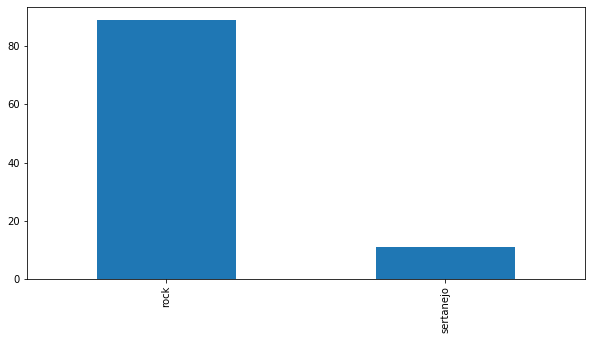

In [50]:
# analyze results
your_playlist_df['predicted_genre'] = predictions
your_playlist_df['predicted_genre'].value_counts().plot(kind='bar', figsize=(10,5))